# My First Convolutional Neural Network : Fashion MNIST
---
#### 실습목표
1. CNN의 기본 아이디어를 안다.
2. CNN의 구조를 그리고, 코드로 옮길 수 있다.

## Real Game : CNN on Fashion MNIST

여기에서는 여러분이 직접 코드를 완성해야 하는 문제가 곳곳에 있습니다!

In [1]:
'''
라이브러리들을 불러오자.
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random as rd
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras

### Data Loading

In [2]:
(train_x, train_y), (test_x, test_y) = keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [3]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [4]:
labels = ["T-shirt/top",  # index 0
            "Trouser",      # index 1
            "Pullover",     # index 2 
            "Dress",        # index 3 
            "Coat",         # index 4
            "Sandal",       # index 5
            "Shirt",        # index 6 
            "Sneaker",      # index 7 
            "Bag",          # index 8 
            "Ankle boot"]   # index 9

print(labels)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


id = 6567
다음 그림은 Pullover 입니다.


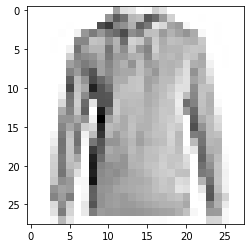

In [5]:
'''
Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

id = rd.randrange(0,10000)

print(f'id = {id}')
print(f'다음 그림은 {labels[test_y[id]]} 입니다.')

plt.imshow(test_x[id], cmap='Greys')
plt.show()

### X : Min-Max Scaling

- 최소값 0, 최대값 1로 통일하는 스케일링

In [9]:
np.max(train_x), np.min(train_x)

(255, 0)

In [10]:
train_x = train_x / 255.0
test_x = test_x / 255.0

### X : Reshape(# of data, 28, 28, 1)

- **끝에 1을 달아서 그레이스케일(흑백)을 명시해준다.**

In [13]:
train_x = train_x.reshape(-1, train_x.shape[1], train_x.shape[2], 1)
test_x = test_x.reshape(-1, test_x.shape[1], test_x.shape[2], 1)

In [14]:
train_x.shape, test_x.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### Y : One-Hot Encoding

In [15]:
# keras.losses.sparse_categorical_crossentropy로 대체

### 코드를 완성해주세요!

- **자유롭게 먼저 해보는 것을 추천**
---
- **구조를 따라서 코딩을 한다면..**

    1. 인풋 레이어
    2. Convolution : 필터수 32개, 사이즈(3, 3), same padding
    3. BatchNormalization
    4. Convolution : 필터수 32개, 사이즈(3, 3), same padding
    5. BatchNormalization
    6. MaxPooling : 사이즈(2,2) 스트라이드(2,2)
    7. DropOut : 25% 비활성화
    8. Convolution : 필터수 64개, 사이즈(3, 3), same padding
    9. BatchNormalization
    10. Convolution : 필터수 64개, 사이즈(3, 3), same padding
    11. BatchNormalization
    12. MaxPooling : 사이즈(2,2) 스트라이드(2,2)
    13. DropOut : 25% 비활성화
    14. Flatten
    15. Fully Connected Layer : 노드 512개
    16. BatchNormalization
    17. 아웃풋 레이어

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, MaxPool2D, Conv2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [61]:
# 1. 세션 클리어
keras.backend.clear_session()

# 2. 모델 연결
il = Input(shape=(28, 28, 1))
cl = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(il)
bl = BatchNormalization()(cl)
cl = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(bl)
bl = BatchNormalization()(cl)
pl = MaxPool2D(pool_size=(2, 2))(bl)
dl = Dropout(0.25)(pl)

cl = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(il)
bl = BatchNormalization()(cl)
cl = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(bl)
bl = BatchNormalization()(cl)
pl = MaxPool2D(pool_size=(2, 2))(bl)
dl = Dropout(0.25)(pl)

fl = Flatten()(dl)
dl = Dense(512, activation='relu')(fl)
bl = BatchNormalization()(dl)
ol = Dense(10, activation='softmax')(bl)

model = keras.models.Model(il, ol)

# 3. 모델 컴파일
model.compile(loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy'], optimizer='adam')

# 4. 요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_2 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0     

### Early Stopping을 활용한 학습

- 조건
    1. validation_split = 0.2
    2. 1 epochs만 관찰해가며 속도가 가장 빠른 batch_size 찾아보기. 128개부터 시작하여 조절해볼 것.
    3. EarlyStopping. val_loss가 5 epoch 전과 비교하여 개선되지 않으면 스탑
    4. 이미지 시각화를 위해 hist 변수에 학습 과정을 넣어주세요.

In [62]:
es = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0,
    verbose=1,
    restore_best_weights=True
)

In [64]:
hist = model.fit(train_x, train_y, validation_split=0.2, epochs=10000, callbacks=[es], batch_size=256)

Epoch 1/10000
188/188 [==============================] - 3s 15ms/step - loss: 0.2729 - accuracy: 0.8995 - val_loss: 11.7469 - val_accuracy: 0.1436
Epoch 2/10000
188/188 [==============================] - 3s 15ms/step - loss: 0.1904 - accuracy: 0.9301 - val_loss: 11.2468 - val_accuracy: 0.2477
Epoch 3/10000
188/188 [==============================] - 3s 14ms/step - loss: 0.1442 - accuracy: 0.9469 - val_loss: 0.7920 - val_accuracy: 0.7899
Epoch 4/10000
188/188 [==============================] - 3s 14ms/step - loss: 0.1177 - accuracy: 0.9575 - val_loss: 0.2389 - val_accuracy: 0.9190
Epoch 5/10000
188/188 [==============================] - 3s 15ms/step - loss: 0.0960 - accuracy: 0.9651 - val_loss: 0.2165 - val_accuracy: 0.9247
Epoch 6/10000
188/188 [==============================] - 3s 14ms/step - loss: 0.0658 - accuracy: 0.9767 - val_loss: 0.2451 - val_accuracy: 0.9223
Epoch 7/10000
188/188 [==============================] - 3s 14ms/step - loss: 0.0524 - accuracy: 0.9815 - val_loss: 0.2432

### 이미지 시각화

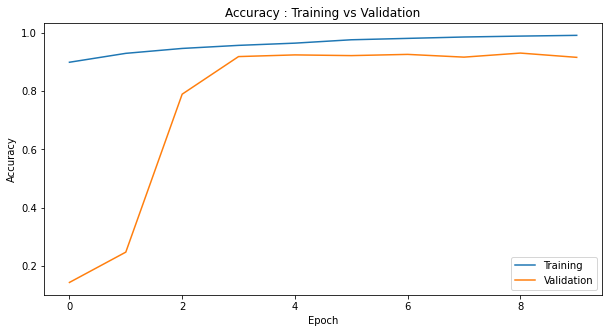

In [65]:
plt.figure(figsize=(10, 5))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

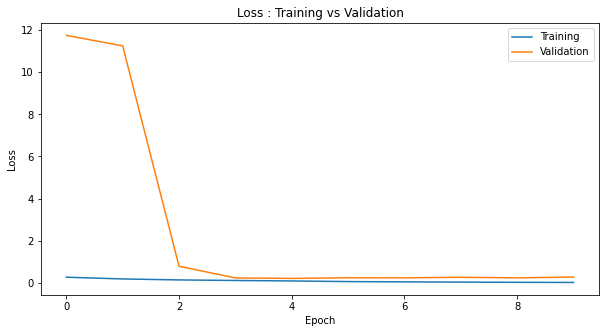

In [66]:
plt.figure(figsize=(10, 5))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

In [67]:
y_pred = model.predict(test_x)
y_pred.shape

313/313 [==============================] - 1s 2ms/step


(10000, 10)

In [68]:
single_y_pred = y_pred.argmax(axis=1)
single_y_pred.shape

(10000,)

In [69]:
print(test_y.shape)
# single_test_y = test_y.argmax(axis=1)
# print(single_test_y.shape)

(10000,)


In [70]:
# test_acc = accuracy_score(single_test_y, single_y_pred)
test_acc = accuracy_score(test_y, single_y_pred)

print(f'테스트셋 정확도 : {test_acc*100:.2f}%' )

테스트셋 정확도 : 91.75%


id = 6161
다음 그림은 숫자 1 입니다.
모델의 예측 : 1
모델의 카테고리별 확률 : [ 0. 99.  0.  0.  0.  0.  0.  0.  0.  0.]
정답입니다


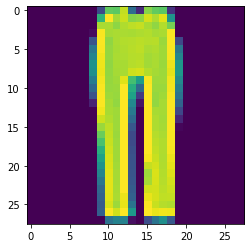

In [71]:
'''
성능 확인을 위해
Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

id = rd.randrange(0,10000)

print(f'id = {id}')
# print(f'다음 그림은 숫자 {single_test_y[id]} 입니다.')
print(f'다음 그림은 숫자 {test_y[id]} 입니다.')
print(f'모델의 예측 : {single_y_pred[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(y_pred[id]*100)}')

# if single_test_y[id] == single_y_pred[id] :
if test_y[id] == single_y_pred[id] :
    print('정답입니다')
else : 
    print('틀렸어요')
    
plt.imshow(test_x[id].reshape([28,-1]))
plt.show()

id = 5442
다음 그림은 숫자 6 입니다.
모델의 예측 : 0
모델의 카테고리별 확률 : [72.  0.  0.  0.  0.  0. 27.  0.  0.  0.]
틀렸어요


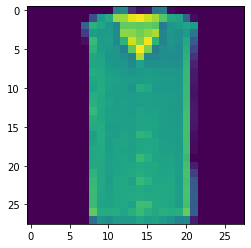

In [72]:
'''
틀린 것만 관찰해보자!

Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

true_false = (test_y==single_y_pred)
f_id = np.where(true_false==False)[0]        # 틀린 것들의 인덱스 반환
f_n = len(f_id)                              # 틀린 것들이 총 몇 개나 될까?

id = f_id[rd.randrange(0,f_n)]

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y[id]} 입니다.')
print(f'모델의 예측 : {single_y_pred[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(y_pred[id]*100)}')

if test_y[id] == single_y_pred[id] :
    print('정답입니다')
else : 
    print('틀렸어요')
    
plt.imshow(test_x[id].reshape([28,-1]))
plt.show()